AttributeError: 'Polygon' object has no attribute 'set_center'

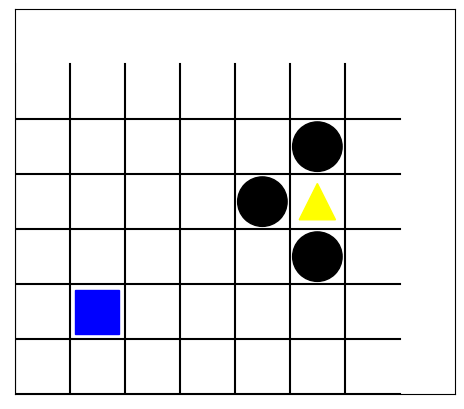

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jul 26 23:03:03 2024

@author: user
"""

# coding: utf-8

# Python Machine Learning, PyTorch Edition by Sebastian Raschka (https://sebastianraschka.com), Yuxi (Hayden) Liu (https://www.mlexample.com/) & Vahid Mirjalili (http://vahidmirjalili.com), Packt Publishing Ltd. 2021
# Code Repository:
# Code License: MIT License (https://github.com/ LICENSE.txt)

#################################################################################
# Chapter 19 - Reinforcement Learning for Decision Making in Complex Environments
#################################################################################

# Script: gridworld_env.py

import numpy as np
from gym import Env
from gym.spaces import Discrete
from collections import defaultdict
import time
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon

CELL_SIZE = 100
MARGIN = 10

def get_coords(row, col, loc='center'):
    xc = (col + 1.5) * CELL_SIZE
    yc = (row + 1.5) * CELL_SIZE
    if loc == 'center':
        return xc, yc
    elif loc == 'interior_corners':
        half_size = CELL_SIZE // 2 - MARGIN
        xl, xr = xc - half_size, xc + half_size
        yt, yb = yc - half_size, yc + half_size
        return [(xl, yt), (xr, yt), (xr, yb), (xl, yb)]
    elif loc == 'interior_triangle':
        x1, y1 = xc, yc + CELL_SIZE // 3
        x2, y2 = xc + CELL_SIZE // 3, yc - CELL_SIZE // 3
        x3, y3 = xc - CELL_SIZE // 3, yc - CELL_SIZE // 3
        return [(x1, y1), (x2, y2), (x3, y3)]

def draw_object(ax, coords_list):
    if len(coords_list) == 1:  # -> circle
        obj = plt.Circle(coords_list[0], 0.45 * CELL_SIZE, color='black')
    elif len(coords_list) == 3:  # -> triangle
        obj = Polygon(coords_list, closed=True, color='yellow')
    elif len(coords_list) > 3:  # -> polygon
        obj = Polygon(coords_list, closed=True, color='blue')
    return obj

class GridWorldEnv(Env):
    def __init__(self, num_rows=4, num_cols=6, delay=0.05):
        self.num_rows = num_rows
        self.num_cols = num_cols

        self.delay = delay

        move_up = lambda row, col: (max(row - 1, 0), col)
        move_down = lambda row, col: (min(row + 1, num_rows - 1), col)
        move_left = lambda row, col: (row, max(col - 1, 0))
        move_right = lambda row, col: (row, min(col + 1, num_cols - 1))

        self.action_defs = {0: move_up, 1: move_right,
                            2: move_down, 3: move_left}

        # Number of states/actions
        nS = num_cols * num_rows
        nA = len(self.action_defs)
        self.grid2state_dict = {(s // num_cols, s % num_cols): s
                                for s in range(nS)}
        self.state2grid_dict = {s: (s // num_cols, s % num_cols)
                                for s in range(nS)}

        # Gold state
        gold_cell = (num_rows // 2, num_cols - 2)

        # Trap states
        trap_cells = [((gold_cell[0] + 1), gold_cell[1]),
                      (gold_cell[0], gold_cell[1] - 1),
                      ((gold_cell[0] - 1), gold_cell[1])]

        gold_state = self.grid2state_dict[gold_cell]
        trap_states = [self.grid2state_dict[(r, c)]
                       for (r, c) in trap_cells]
        self.terminal_states = [gold_state] + trap_states

        # Build the transition probability
        P = defaultdict(dict)
        for s in range(nS):
            row, col = self.state2grid_dict[s]
            P[s] = defaultdict(list)
            for a in range(nA):
                action = self.action_defs[a]
                next_s = self.grid2state_dict[action(row, col)]

                # Terminal state
                if self.is_terminal(next_s):
                    r = (1.0 if next_s == self.terminal_states[0]
                         else -1.0)
                else:
                    r = 0.0
                if self.is_terminal(s):
                    done = True
                    next_s = s
                else:
                    done = False
                P[s][a] = [(1.0, next_s, r, done)]

        # Initial state distribution
        isd = np.zeros(nS)
        isd[0] = 1.0

        self.nS = nS
        self.nA = nA
        self.P = P
        self.isd = isd

        self.viewer = None
        self._build_display(gold_cell, trap_cells)

    def is_terminal(self, state):
        return state in self.terminal_states

    def _build_display(self, gold_cell, trap_cells):
        self.fig, self.ax = plt.subplots(figsize=(self.num_cols, self.num_rows))
        self.ax.set_xlim(0, (self.num_cols + 2) * CELL_SIZE)
        self.ax.set_ylim(0, (self.num_rows + 2) * CELL_SIZE)
        self.ax.set_aspect('equal')
        self.ax.set_xticks([])
        self.ax.set_yticks([])

        # Draw grid
        for row in range(self.num_rows + 1):
            self.ax.plot([0, (self.num_cols + 1) * CELL_SIZE], [row * CELL_SIZE, row * CELL_SIZE], color='black')

        for col in range(self.num_cols + 1):
            self.ax.plot([col * CELL_SIZE, col * CELL_SIZE], [0, (self.num_rows + 1) * CELL_SIZE], color='black')

        # Traps
        for cell in trap_cells:
            trap_coords = get_coords(*cell, loc='center')
            self.ax.add_patch(draw_object(self.ax, [trap_coords]))

        # Gold
        gold_coords = get_coords(*gold_cell, loc='interior_triangle')
        self.ax.add_patch(draw_object(self.ax, gold_coords))

        # Agent
        if (os.path.exists('robot-coordinates.pkl') and CELL_SIZE == 100):
            agent_coords = pickle.load(open('robot-coordinates.pkl', 'rb'))
            starting_coords = get_coords(0, 0, loc='center')
            agent_coords += np.array(starting_coords)
        else:
            agent_coords = get_coords(0, 0, loc='interior_corners')
        self.agent_patch = draw_object(self.ax, agent_coords)
        self.ax.add_patch(self.agent_patch)

    def reset(self):
        self.s = 0
        return self.s

    def step(self, action):
        transitions = self.P[self.s][action]
        transition = transitions[0]  # deterministic environment
        next_state, reward, done = transition[1], transition[2], transition[3]
        self.s = next_state
        return next_state, reward, done

    def render(self, mode='human', done=False):
        if done:
            sleep_time = 1
        else:
            sleep_time = self.delay

        x_coord, y_coord = self.state2grid_dict[self.s]
        x_coord = (x_coord + 0.5) * CELL_SIZE
        y_coord = (y_coord + 0.5) * CELL_SIZE
        self.agent_patch.set_center((x_coord, y_coord))
        plt.draw()
        plt.pause(self.delay)

    def close(self):
        if self.viewer:
            plt.close(self.fig)
            self.viewer = None

if __name__ == '__main__':
    env = GridWorldEnv(5, 6)
    for i in range(1):
        s = env.reset()
        env.render(mode='human', done=False)

        while True:
            action = np.random.choice(env.nA)
            res = env.step(action)
            print('Action ', env.s, action, ' -> ', res)
            env.render(mode='human', done=res[2])
            if res[2]:
                break

    env.close()


NameError: name 'trap_cells' is not defined

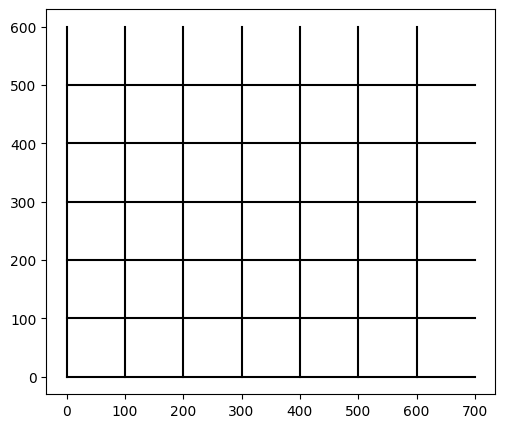

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jul 26 23:03:03 2024

@author: user
"""

import numpy as np
from gym import Env
from gym.spaces import Discrete
from collections import defaultdict
import time
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

CELL_SIZE = 100
MARGIN = 10

def get_coords(row, col, loc='center'):
    xc = (col + 1.5) * CELL_SIZE
    yc = (row + 1.5) * CELL_SIZE
    if loc == 'center':
        return xc, yc
    elif loc == 'interior_corners':
        half_size = CELL_SIZE // 2 - MARGIN
        xl, xr = xc - half_size, xc + half_size
        yt, yb = yc - half_size, yc + half_size
        return [(xl, yt), (xr, yt), (xr, yb), (xl, yb)]
    elif loc == 'interior_triangle':
        x1, y1 = xc, yc + CELL_SIZE // 3
        x2, y2 = xc + CELL_SIZE // 3, yc - CELL_SIZE // 3
        x3, y3 = xc - CELL_SIZE // 3, yc - CELL_SIZE // 3
        return [(x1, y1), (x2, y2), (x3, y3)]

def draw_object(ax, coords_list):
    if len(coords_list) == 1:  # -> circle
        obj = plt.Circle(coords_list[0], 0.45 * CELL_SIZE, color='black')
    elif len(coords_list) == 3:  # -> triangle
        obj = Polygon(coords_list, closed=True, color='yellow')
    elif len(coords_list) > 3:  # -> polygon
        obj = Polygon(coords_list, closed=True, color='blue')
    return obj

class GridWorldEnv(Env):
    def __init__(self, num_rows=4, num_cols=6, delay=0.05):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.delay = delay

        move_up = lambda row, col: (max(row - 1, 0), col)
        move_down = lambda row, col: (min(row + 1, num_rows - 1), col)
        move_left = lambda row, col: (row, max(col - 1, 0))
        move_right = lambda row, col: (row, min(col + 1, num_cols - 1))

        self.action_defs = {0: move_up, 1: move_right,
                            2: move_down, 3: move_left}

        # Number of states/actions
        nS = num_cols * num_rows
        nA = len(self.action_defs)
        self.grid2state_dict = {(s // num_cols, s % num_cols): s
                                for s in range(nS)}
        self.state2grid_dict = {s: (s // num_cols, s % num_cols)
                                for s in range(nS)}

        # Gold state
        gold_cell = (num_rows // 2, num_cols - 2)

        # Trap states
        trap_cells = [((gold_cell[0] + 1), gold_cell[1]),
                      (gold_cell[0], gold_cell[1] - 1),
                      ((gold_cell[0] - 1), gold_cell[1])]

        gold_state = self.grid2state_dict[gold_cell]
        trap_states = [self.grid2state_dict[(r, c)]
                       for (r, c) in trap_cells]
        self.terminal_states = [gold_state] + trap_states

        # Build the transition probability
        P = defaultdict(dict)
        for s in range(nS):
            row, col = self.state2grid_dict[s]
            P[s] = defaultdict(list)
            for a in range(nA):
                action = self.action_defs[a]
                next_s = self.grid2state_dict[action(row, col)]

                # Terminal state
                if self.is_terminal(next_s):
                    r = (1.0 if next_s == self.terminal_states[0]
                         else -1.0)
                else:
                    r = 0.0
                if self.is_terminal(s):
                    done = True
                    next_s = s
                else:
                    done = False
                P[s][a] = [(1.0, next_s, r, done)]

        # Initial state distribution
        isd = np.zeros(nS)
        isd[0] = 1.0

        self.nS = nS
        self.nA = nA
        self.P = P
        self.isd = isd

        self.viewer = None
        self._build_display(gold_cell, trap_cells)

    def is_terminal(self, state):
        return state in self.terminal_states

    def _build_display(self, gold_cell, trap_cells):
        self.fig, self.ax = plt.subplots(figsize=(self.num_cols, self.num_rows))
        self.ax.set_xlim(0, (self.num_cols + 2) * CELL_SIZE)
        self.ax.set_ylim(0, (self.num_rows + 2) * CELL_SIZE)
        self.ax.set_aspect('equal')
        self.ax.set_xticks([])
        self.ax.set_yticks([])

        # Draw grid
        for row in range(self.num_rows + 1):
            self.ax.plot([0, (self.num_cols + 1) * CELL_SIZE], [row * CELL_SIZE, row * CELL_SIZE], color='black')

        for col in range(self.num_cols + 1):
            self.ax.plot([col * CELL_SIZE, col * CELL_SIZE], [0, (self.num_rows + 1) * CELL_SIZE], color='black')

        # Traps
        for cell in trap_cells:
            trap_coords = get_coords(*cell, loc='center')
            self.ax.add_patch(draw_object(self.ax, [trap_coords]))

        # Gold
        gold_coords = get_coords(*gold_cell, loc='interior_triangle')
        self.ax.add_patch(draw_object(self.ax, gold_coords))

        # Agent
        if (os.path.exists('robot-coordinates.pkl') and CELL_SIZE == 100):
            agent_coords = pickle.load(open('robot-coordinates.pkl', 'rb'))
            starting_coords = get_coords(0, 0, loc='center')
            agent_coords += np.array(starting_coords)
        else:
            agent_coords = get_coords(0, 0, loc='interior_corners')
        self.agent_patch = draw_object(self.ax, agent_coords)
        self.ax.add_patch(self.agent_patch)

    def reset(self):
        self.s = 0
        return self.s

    def step(self, action):
        transitions = self.P[self.s][action]
        transition = transitions[0]  # deterministic environment
        next_state, reward, done = transition[1], transition[2], transition[3]
        self.s = next_state
        return next_state, reward, done

    def render(self, mode='human', done=False):
        if done:
            sleep_time = 1
        else:
            sleep_time = self.delay

        self.ax.clear()  # Clear previous graphics
        
        # Redraw grid
        for row in range(self.num_rows + 1):
            self.ax.plot([0, (self.num_cols + 1) * CELL_SIZE], [row * CELL_SIZE, row * CELL_SIZE], color='black')

        for col in range(self.num_cols + 1):
            self.ax.plot([col * CELL_SIZE, col * CELL_SIZE], [0, (self.num_rows + 1) * CELL_SIZE], color='black')

        # Redraw traps
        for cell in trap_cells:
            trap_coords = get_coords(*cell, loc='center')
            self.ax.add_patch(draw_object(self.ax, [trap_coords]))

        # Redraw gold
        gold_coords = get_coords(*gold_cell, loc='interior_triangle')
        self.ax.add_patch(draw_object(self.ax, gold_coords))

        # Update agent position
        x_coord, y_coord = self.state2grid_dict[self.s]
        agent_coords = get_coords(x_coord, y_coord, loc='interior_corners')
        if isinstance(self.agent_patch, Polygon):
            self.agent_patch.set_xy(agent_coords)
        else:
            self.agent_patch = draw_object(self.ax, agent_coords)
            self.ax.add_patch(self.agent_patch)

        self.ax.set_xlim(0, (self.num_cols + 2) * CELL_SIZE)
        self.ax.set_ylim(0, (self.num_rows + 2) * CELL_SIZE)
        self.ax.set_aspect('equal')
        self.ax.set_xticks([])
        self.ax.set_yticks([])

        plt.draw()
        plt.pause(sleep_time)

    def close(self):
        if self.viewer:
            plt.close(self.fig)
            self.viewer = None

if __name__ == '__main__':
    env = GridWorldEnv(5, 6)
    for i in range(1):
        s = env.reset()
        env.render(mode='human', done=False)

        while True:
            action = np.random.choice(env.nA)
            res = env.step(action)
            print('Action ', env.s, action, ' -> ', res)
            env.render(mode='human', done=res[2])
            if res[2]:  # done
                break


In [ ]:
import numpy as np
from gym import Env
from gym.spaces import Discrete
from collections import defaultdict
import time
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon


好的，下面是對每行代碼的詳細解釋：

### 導入必要的庫

```python
import numpy as np
```
- **`numpy`**: Python中用於科學計算的核心庫。它提供了高效的多維數組對象以及與這些數組進行操作的各種函數。

```python
from gym import Env
```
- **`gym`**: OpenAI Gym庫，用於構建和操作強化學習環境。
- **`Env`**: Gym庫中的基類，用於定義所有強化學習環境的基本接口和功能。

```python
from gym.spaces import Discrete
```
- **`Discrete`**: Gym庫中的類，用於定義離散動作空間或狀態空間。它表示動作或狀態空間中的每個可能值。

```python
from collections import defaultdict
```
- **`defaultdict`**: `collections`模塊中的類，類似於字典，但在鍵不存在時可以自動初始化一個默認值，避免KeyError。

```python
import time
```
- **`time`**: Python標準庫中的模塊，提供與時間相關的各種函數，如延遲、時間測量等。

```python
import pickle
```
- **`pickle`**: Python標準庫中的模塊，用於序列化和反序列化Python對象，可以將對象存儲到文件或從文件加載。

```python
import os
```
- **`os`**: Python標準庫中的模塊，提供與操作系統相關的功能，如文件和目錄操作、環境變量等。

```python
import matplotlib.pyplot as plt
```
- **`matplotlib.pyplot`**: Matplotlib庫中的模塊，提供了類似於MATLAB的繪圖API，用於創建各種圖形和圖表。

```python
from matplotlib.patches import Rectangle
```
- **`Rectangle`**: Matplotlib中的類，用於創建和操作矩形對象，可以添加到繪圖中以表示不同的形狀或區域。

```python
from matplotlib.patches import Polygon
```
- **`Polygon`**: Matplotlib中的類，用於創建和操作多邊形對象，可以添加到繪圖中以表示不同的形狀或區域。

In [ ]:
CELL_SIZE = 100
MARGIN = 10

def get_coords(row, col, loc='center'):
    xc = (col + 1.5) * CELL_SIZE
    yc = (row + 1.5) * CELL_SIZE
    if loc == 'center':
        return xc, yc
    elif loc == 'interior_corners':
        half_size = CELL_SIZE // 2 - MARGIN
        xl, xr = xc - half_size, xc + half_size
        yt, yb = yc - half_size, yc + half_size
        return [(xl, yt), (xr, yt), (xr, yb), (xl, yb)]
    elif loc == 'interior_triangle':
        x1, y1 = xc, yc + CELL_SIZE // 3
        x2, y2 = xc + CELL_SIZE // 3, yc - CELL_SIZE // 3
        x3, y3 = xc - CELL_SIZE // 3, yc - CELL_SIZE // 3
        return [(x1, y1), (x2, y2), (x3, y3)]

def draw_object(ax, coords_list):
    if len(coords_list) == 1:  # -> circle
        obj = plt.Circle(coords_list[0], 0.45 * CELL_SIZE, color='black')
    elif len(coords_list) == 3:  # -> triangle
        obj = Polygon(coords_list, closed=True, color='yellow')
    elif len(coords_list) > 3:  # -> polygon
        obj = Polygon(coords_list, closed=True, color='blue')
    return obj


好的，我將詳細解釋這段代碼的每一行及其參數意義。

### 常量定義

```python
CELL_SIZE = 100
MARGIN = 10
```
- **`CELL_SIZE`**: 每個格子的大小，單位是像素。
- **`MARGIN`**: 用於繪製物體時的內邊距，單位是像素。

### `get_coords` 函數

```python
def get_coords(row, col, loc='center'):
```
- **`row`**: 格子的行號。
- **`col`**: 格子的列號。
- **`loc`**: 物體的位置類型，默認為 `'center'`。

```python
    xc = (col + 1.5) * CELL_SIZE
    yc = (row + 1.5) * CELL_SIZE
```
- **`xc`**: 計算中心點的x坐標。`col + 1.5` 是為了將格子中心點定位在正確的位置。
- **`yc`**: 計算中心點的y坐標。`row + 1.5` 是為了將格子中心點定位在正確的位置。

```python
    if loc == 'center':
        return xc, yc
```
- 如果 `loc` 為 `'center'`，則返回格子中心點的座標 `(xc, yc)`。

```python
    elif loc == 'interior_corners':
        half_size = CELL_SIZE // 2 - MARGIN
        xl, xr = xc - half_size, xc + half_size
        yt, yb = yc - half_size, yc + half_size
        return [(xl, yt), (xr, yt), (xr, yb), (xl, yb)]
```
- 如果 `loc` 為 `'interior_corners'`，則計算內部矩形的四個角的座標：
  - **`half_size`**: 計算內部矩形的半邊長。
  - **`xl`**: 左邊界的x坐標。
  - **`xr`**: 右邊界的x坐標。
  - **`yt`**: 上邊界的y坐標。
  - **`yb`**: 下邊界的y坐標。
  - 返回內部矩形的四個角的座標列表 `[(xl, yt), (xr, yt), (xr, yb), (xl, yb)]`。

```python
    elif loc == 'interior_triangle':
        x1, y1 = xc, yc + CELL_SIZE // 3
        x2, y2 = xc + CELL_SIZE // 3, yc - CELL_SIZE // 3
        x3, y3 = xc - CELL_SIZE // 3, yc - CELL_SIZE // 3
        return [(x1, y1), (x2, y2), (x3, y3)]
```
- 如果 `loc` 為 `'interior_triangle'`，則計算內部三角形的三個頂點的座標：
  - **`x1, y1`**: 三角形頂部頂點的座標。
  - **`x2, y2`**: 三角形右底部頂點的座標。
  - **`x3, y3`**: 三角形左底部頂點的座標。
  - 返回內部三角形的三個頂點的座標列表 `[(x1, y1), (x2, y2), (x3, y3)]`。

### `draw_object` 函數

```python
def draw_object(ax, coords_list):
```
- **`ax`**: Matplotlib的軸對象，用於繪製。
- **`coords_list`**: 座標列表，根據物體的類型決定座標的數量。

```python
    if len(coords_list) == 1:  # -> circle
        obj = plt.Circle(coords_list[0], 0.45 * CELL_SIZE, color='black')
```
- 如果 `coords_list` 的長度為1，則繪製圓形：
  - **`coords_list[0]`**: 圓心的座標。
  - **`0.45 * CELL_SIZE`**: 圓的半徑。
  - **`color='black'`**: 圓的顏色為黑色。

```python
    elif len(coords_list) == 3:  # -> triangle
        obj = Polygon(coords_list, closed=True, color='yellow')
```
- 如果 `coords_list` 的長度為3，則繪製三角形：
  - **`Polygon(coords_list, closed=True, color='yellow')`**: 使用座標列表創建封閉的黃色三角形。

```python
    elif len(coords_list) > 3:  # -> polygon
        obj = Polygon(coords_list, closed=True, color='blue')
```
- 如果 `coords_list` 的長度大於3，則繪製多邊形：
  - **`Polygon(coords_list, closed=True, color='blue')`**: 使用座標列表創建封閉的藍色多邊形。

```python
    return obj
```
- 返回創建的圖形對象 `obj`。

In [ ]:
class GridWorldEnv(Env):
    def __init__(self, num_rows=4, num_cols=6, delay=0.05):
        self.num_rows = num_rows
        self.num_cols = num_cols

        self.delay = delay

        move_up = lambda row, col: (max(row - 1, 0), col)
        move_down = lambda row, col: (min(row + 1, num_rows - 1), col)
        move_left = lambda row, col: (row, max(col - 1, 0))
        move_right = lambda row, col: (row, min(col + 1, num_cols - 1))

        self.action_defs = {0: move_up, 1: move_right,
                            2: move_down, 3: move_left}

        # Number of states/actions
        nS = num_cols * num_rows
        nA = len(self.action_defs)
        self.grid2state_dict = {(s // num_cols, s % num_cols): s
                                for s in range(nS)}
        self.state2grid_dict = {s: (s // num_cols, s % num_cols)
                                for s in range(nS)}

        # Gold state
        gold_cell = (num_rows // 2, num_cols - 2)

        # Trap states
        trap_cells = [((gold_cell[0] + 1), gold_cell[1]),
                      (gold_cell[0], gold_cell[1] - 1),
                      ((gold_cell[0] - 1), gold_cell[1])]

        gold_state = self.grid2state_dict[gold_cell]
        trap_states = [self.grid2state_dict[(r, c)]
                       for (r, c) in trap_cells]
        self.terminal_states = [gold_state] + trap_states

        # Build the transition probability
        P = defaultdict(dict)
        for s in range(nS):
            row, col = self.state2grid_dict[s]
            P[s] = defaultdict(list)
            for a in range(nA):
                action = self.action_defs[a]
                next_s = self.grid2state_dict[action(row, col)]

                # Terminal state
                if self.is_terminal(next_s):
                    r = (1.0 if next_s == self.terminal_states[0]
                         else -1.0)
                else:
                    r = 0.0
                if self.is_terminal(s):
                    done = True
                    next_s = s
                else:
                    done = False
                P[s][a] = [(1.0, next_s, r, done)]

        # Initial state distribution
        isd = np.zeros(nS)
        isd[0] = 1.0

        self.nS = nS
        self.nA = nA
        self.P = P
        self.isd = isd

        self.viewer = None
        self._build_display(gold_cell, trap_cells)


### 類別 `GridWorldEnv` 初始化

```python
class GridWorldEnv(Env):
```
這行代碼定義了一個繼承自 `gym.Env` 的類，表示一個 Grid World 環境。

#### `__init__` 方法

```python
    def __init__(self, num_rows=4, num_cols=6, delay=0.05):
```
- **`num_rows`**: 網格世界的行數，默認值為 4。
- **`num_cols`**: 網格世界的列數，默認值為 6。
- **`delay`**: 每次渲染之間的延遲時間，默認值為 0.05 秒。

```python
        self.num_rows = num_rows
        self.num_cols = num_cols

        self.delay = delay
```
這幾行代碼將傳入的參數賦值給類的實例變量。

### 定義動作

```python
        move_up = lambda row, col: (max(row - 1, 0), col)
        move_down = lambda row, col: (min(row + 1, num_rows - 1), col)
        move_left = lambda row, col: (row, max(col - 1, 0))
        move_right = lambda row, col: (row, min(col + 1, num_cols - 1))
```
這幾行代碼定義了四個 lambda 函數，用來表示移動的動作：
- **`move_up`**: 向上移動，如果在邊界則保持不變。
- **`move_down`**: 向下移動，如果在邊界則保持不變。
- **`move_left`**: 向左移動，如果在邊界則保持不變。
- **`move_right`**: 向右移動，如果在邊界則保持不變。

```python
        self.action_defs = {0: move_up, 1: move_right,
                            2: move_down, 3: move_left}
```
這行代碼將動作映射到動作定義的字典 `self.action_defs`。

### 狀態和動作的數量

```python
        nS = num_cols * num_rows
        nA = len(self.action_defs)
```
- **`nS`**: 狀態的總數，即網格世界中的格子數。
- **`nA`**: 動作的總數，即 4 個。

```python
        self.grid2state_dict = {(s // num_cols, s % num_cols): s
                                for s in range(nS)}
        self.state2grid_dict = {s: (s // num_cols, s % num_cols)
                                for s in range(nS)}
```
- **`self.grid2state_dict`**: 將網格坐標映射到狀態編號的字典。
- **`self.state2grid_dict`**: 將狀態編號映射到網格坐標的字典。

### 終點和陷阱狀態

```python
        gold_cell = (num_rows // 2, num_cols - 2)
```
- **`gold_cell`**: 金幣位置的格子坐標。

```python
        trap_cells = [((gold_cell[0] + 1), gold_cell[1]),
                      (gold_cell[0], gold_cell[1] - 1),
                      ((gold_cell[0] - 1), gold_cell[1])]
```
- **`trap_cells`**: 陷阱位置的格子坐標列表。

```python
        gold_state = self.grid2state_dict[gold_cell]
        trap_states = [self.grid2state_dict[(r, c)]
                       for (r, c) in trap_cells]
        self.terminal_states = [gold_state] + trap_states
```
- **`gold_state`**: 金幣位置對應的狀態。
- **`trap_states`**: 陷阱位置對應的狀態列表。
- **`self.terminal_states`**: 終點狀態列表，包括金幣和陷阱。

### 建立轉移概率

```python
        P = defaultdict(dict)
        for s in range(nS):
            row, col = self.state2grid_dict[s]
            P[s] = defaultdict(list)
            for a in range(nA):
                action = self.action_defs[a]
                next_s = self.grid2state_dict[action(row, col)]
```
- **`P`**: 初始化轉移概率的字典。
- 遍歷所有狀態和動作來填充轉移概率 `P`。

```python
                if self.is_terminal(next_s):
                    r = (1.0 if next_s == self.terminal_states[0]
                         else -1.0)
                else:
                    r = 0.0
```
- 判斷下一狀態是否是終點狀態，如果是金幣狀態，則獎勵為 1.0，否則獎勵為 -1.0。

```python
                if self.is_terminal(s):
                    done = True
                    next_s = s
                else:
                    done = False
```
- 判斷當前狀態是否是終點狀態，如果是，則設置 `done` 為 True，並保持在當前狀態。

```python
                P[s][a] = [(1.0, next_s, r, done)]
```
- 將轉移概率信息添加到 `P` 中。

### 初始狀態分佈

```python
        isd = np.zeros(nS)
        isd[0] = 1.0
```
- **`isd`**: 初始化狀態分佈，表示從狀態 0 開始。

```python
        self.nS = nS
        self.nA = nA
        self.P = P
        self.isd = isd
```
- 將 `nS`、`nA`、`P` 和 `isd` 賦值給實例變量。

### 顯示初始化

```python
        self.viewer = None
        self._build_display(gold_cell, trap_cells)
```
- **`self.viewer`**: 初始化顯示為 None。
- **`self._build_display(gold_cell, trap_cells)`**: 調用 `_build_display` 方法來初始化顯示。

這些代碼定義了 `GridWorldEnv` 類的初始化邏輯，設置了網格世界的大小、動作、狀態、終點和陷阱位置，並建立了狀態轉移概率。

In [ ]:
    def is_terminal(self, state):
        return state in self.terminal_states

    def _build_display(self, gold_cell, trap_cells):
        self.fig, self.ax = plt.subplots(figsize=(self.num_cols, self.num_rows))
        self.ax.set_xlim(0, (self.num_cols + 2) * CELL_SIZE)
        self.ax.set_ylim(0, (self.num_rows + 2) * CELL_SIZE)
        self.ax.set_aspect('equal')
        self.ax.set_xticks([])
        self.ax.set_yticks([])

        # Draw grid
        for row in range(self.num_rows + 1):
            self.ax.plot([0, (self.num_cols + 1) * CELL_SIZE], [row * CELL_SIZE, row * CELL_SIZE], color='black')

        for col in range(self.num_cols + 1):
            self.ax.plot([col * CELL_SIZE, col * CELL_SIZE], [0, (self.num_rows + 1) * CELL_SIZE], color='black')

        # Traps
        for cell in trap_cells:
            trap_coords = get_coords(*cell, loc='center')
            self.ax.add_patch(draw_object(self.ax, [trap_coords]))

        # Gold
        gold_coords = get_coords(*gold_cell, loc='interior_triangle')
        self.ax.add_patch(draw_object(self.ax, gold_coords))

        # Agent
        if (os.path.exists('robot-coordinates.pkl') and CELL_SIZE == 100):
            agent_coords = pickle.load(open('robot-coordinates.pkl', 'rb'))
            starting_coords = get_coords(0, 0, loc='center')
            agent_coords += np.array(starting_coords)
        else:
            agent_coords = get_coords(0, 0, loc='interior_corners')
        self.agent_patch = draw_object(self.ax, agent_coords)
        self.ax.add_patch(self.agent_patch)


### 方法 `is_terminal` 和 `_build_display`

#### `is_terminal` 方法

```python
def is_terminal(self, state):
    return state in self.terminal_states
```
- **`state`**: 當前狀態。
- 這行代碼檢查傳入的狀態是否在終點狀態列表中。如果是，返回 `True`；否則，返回 `False`。

#### `_build_display` 方法

```python
def _build_display(self, gold_cell, trap_cells):
    self.fig, self.ax = plt.subplots(figsize=(self.num_cols, self.num_rows))
```
- **`gold_cell`**: 金幣的位置。
- **`trap_cells`**: 陷阱的位置列表。
- 這行代碼使用 `matplotlib` 創建一個新的圖形和軸對象，圖形大小根據列數和行數設置。

```python
    self.ax.set_xlim(0, (self.num_cols + 2) * CELL_SIZE)
    self.ax.set_ylim(0, (self.num_rows + 2) * CELL_SIZE)
    self.ax.set_aspect('equal')
    self.ax.set_xticks([])
    self.ax.set_yticks([])
```
- 設置軸的顯示範圍：
  - x 軸範圍從 0 到 `(self.num_cols + 2) * CELL_SIZE`
  - y 軸範圍從 0 到 `(self.num_rows + 2) * CELL_SIZE`
- **`set_aspect('equal')`**: 設置軸的縱橫比為相等。
- **`set_xticks([])`** 和 **`set_yticks([])`**: 移除 x 軸和 y 軸的刻度。

```python
    for row in range(self.num_rows + 1):
        self.ax.plot([0, (self.num_cols + 1) * CELL_SIZE], [row * CELL_SIZE, row * CELL_SIZE], color='black')
```
- 畫水平線來顯示網格：
  - 從 `0` 到 `(self.num_cols + 1) * CELL_SIZE` 的範圍。
  - 每一行 `row * CELL_SIZE` 的位置。

```python
    for col in range(self.num_cols + 1):
        self.ax.plot([col * CELL_SIZE, col * CELL_SIZE], [0, (self.num_rows + 1) * CELL_SIZE], color='black')
```
- 畫垂直線來顯示網格：
  - 從 `0` 到 `(self.num_rows + 1) * CELL_SIZE` 的範圍。
  - 每一列 `col * CELL_SIZE` 的位置。

### 畫陷阱

```python
    for cell in trap_cells:
        trap_coords = get_coords(*cell, loc='center')
        self.ax.add_patch(draw_object(self.ax, [trap_coords]))
```
- **`trap_cells`**: 陷阱位置列表。
- 遍歷每個陷阱：
  - 使用 `get_coords` 方法獲取陷阱的中心坐標。
  - 使用 `draw_object` 方法在軸上添加陷阱。

### 畫金幣

```python
    gold_coords = get_coords(*gold_cell, loc='interior_triangle')
    self.ax.add_patch(draw_object(self.ax, gold_coords))
```
- **`gold_cell`**: 金幣位置。
- 使用 `get_coords` 方法獲取金幣的三角形內部坐標。
- 使用 `draw_object` 方法在軸上添加金幣。

### 畫代理（agent）

```python
    if (os.path.exists('robot-coordinates.pkl') and CELL_SIZE == 100):
        agent_coords = pickle.load(open('robot-coordinates.pkl', 'rb'))
        starting_coords = get_coords(0, 0, loc='center')
        agent_coords += np.array(starting_coords)
    else:
        agent_coords = get_coords(0, 0, loc='interior_corners')
```
- 檢查文件 `'robot-coordinates.pkl'` 是否存在且 `CELL_SIZE` 是否等於 100：
  - 如果存在，從文件中加載代理的坐標，並將其加到初始坐標上。
  - 否則，使用 `get_coords` 方法獲取代理的內部角落坐標。

```python
    self.agent_patch = draw_object(self.ax, agent_coords)
    self.ax.add_patch(self.agent_patch)
```
- 使用 `draw_object` 方法在軸上添加代理。
- **`self.agent_patch`**: 保存代理的圖形對象，以便後續更新。

這些代碼定義了 `_build_display` 方法，該方法設置了網格世界的圖形顯示，包括網格、陷阱、金幣和代理的位置。

In [ ]:
    def reset(self):
        self.s = 0
        return self.s

    def step(self, action):
        transitions = self.P[self.s][action]
        transition = transitions[0]  # deterministic environment
        next_state, reward, done = transition[1], transition[2], transition[3]
        self.s = next_state
        return next_state, reward, done

    def render(self, mode='human', done=False):
        if done:
            sleep_time = 1
        else:
            sleep_time = self.delay

        x_coord, y_coord = self.state2grid_dict[self.s]
        x_coord = (x_coord + 0.5) * CELL_SIZE
        y_coord = (y_coord + 0.5) * CELL_SIZE
        self.agent_patch.set_center((x_coord, y_coord))
        plt.draw()
        plt.pause(self.delay)

    def close(self):
        if self.viewer:
            plt.close(self.fig)
            self.viewer = None


### 方法 `reset`

```python
def reset(self):
    self.s = 0
    return self.s
```
- **`reset` 方法**: 重置環境。
  - **`self.s = 0`**: 將當前狀態設置為初始狀態 `0`。
  - **`return self.s`**: 返回當前狀態 `0`。

### 方法 `step`

```python
def step(self, action):
    transitions = self.P[self.s][action]
    transition = transitions[0]  # deterministic environment
    next_state, reward, done = transition[1], transition[2], transition[3]
    self.s = next_state
    return next_state, reward, done
```
- **`step` 方法**: 執行指定的動作，更新環境狀態並返回轉移信息。
  - **`action`**: 採取的動作。
  - **`transitions = self.P[self.s][action]`**: 根據當前狀態 `self.s` 和動作 `action` 獲取轉移概率。
  - **`transition = transitions[0]`**: 由於是確定性環境，取唯一的轉移。
  - **`next_state, reward, done = transition[1], transition[2], transition[3]`**: 提取下個狀態、獎勵和是否結束標誌。
  - **`self.s = next_state`**: 更新當前狀態為下個狀態。
  - **`return next_state, reward, done`**: 返回下個狀態、獎勵和是否結束標誌。

### 方法 `render`

```python
def render(self, mode='human', done=False):
    if done:
        sleep_time = 1
    else:
        sleep_time = self.delay

    x_coord, y_coord = self.state2grid_dict[self.s]
    x_coord = (x_coord + 0.5) * CELL_SIZE
    y_coord = (y_coord + 0.5) * CELL_SIZE
    self.agent_patch.set_center((x_coord, y_coord))
    plt.draw()
    plt.pause(self.delay)
```
- **`render` 方法**: 在環境中顯示當前狀態。
  - **`mode='human'`**: 顯示模式（此處未使用）。
  - **`done=False`**: 指示是否為終點狀態。
  - **`if done`**: 如果為終點狀態，設置 `sleep_time` 為 1 秒，否則設置為 `self.delay`。
  - **`x_coord, y_coord = self.state2grid_dict[self.s]`**: 根據當前狀態 `self.s` 獲取 x 和 y 坐標。
  - **`x_coord = (x_coord + 0.5) * CELL_SIZE`** 和 **`y_coord = (y_coord + 0.5) * CELL_SIZE`**: 計算顯示坐標。
  - **`self.agent_patch.set_center((x_coord, y_coord))`**: 更新代理的位置。
  - **`plt.draw()`** 和 **`plt.pause(self.delay)`**: 繪製並暫停顯示。

### 方法 `close`

```python
def close(self):
    if self.viewer:
        plt.close(self.fig)
        self.viewer = None
```
- **`close` 方法**: 關閉顯示環境。
  - **`if self.viewer`**: 如果顯示窗口存在。
  - **`plt.close(self.fig)`**: 關閉顯示窗口。
  - **`self.viewer = None`**: 將顯示窗口設置為 `None`。

這些方法定義了環境的基本操作，包括重置、步進、渲染和關閉顯示。

In [ ]:
if __name__ == '__main__':
    env = GridWorldEnv(5, 6)
    for i in range(1):
        s = env.reset()
        env.render(mode='human', done=False)

        while True:
            action = np.random.choice(env.nA)
            res = env.step(action)
            print('Action ', env.s, action, ' -> ', res)
            env.render(mode='human', done=res[2])
            if res[2]:
                break

    env.close()


### `if __name__ == '__main__':`

這是一個 Python 模塊的標準方式，用來確保下面的代碼只有在該模塊作為主程序運行時才會執行。

### `env = GridWorldEnv(5, 6)`

```python
env = GridWorldEnv(5, 6)
```
- **`GridWorldEnv`**: 創建一個 5 行 6 列的網格世界環境實例。
- **`5` 和 `6`**: 指定環境的行數和列數。

### `for i in range(1):`

```python
for i in range(1):
```
- **`for` 循環**: 循環一次。在這種情況下，因為範圍是 1，所以循環只會執行一次。
- **`i`**: 循環變量，但這裡沒有實際使用。

### `s = env.reset()`

```python
s = env.reset()
```
- **`env.reset()`**: 重置環境到初始狀態，並返回初始狀態。
- **`s`**: 保存初始狀態。

### `env.render(mode='human', done=False)`

```python
env.render(mode='human', done=False)
```
- **`env.render()`**: 渲染環境以顯示當前狀態。
- **`mode='human'`**: 顯示模式。
- **`done=False`**: 指示環境未達到終點狀態。

### `while True:`

```python
while True:
```
- **`while True`**: 無限循環，直到手動中斷或遇到 `break`。

### `action = np.random.choice(env.nA)`

```python
action = np.random.choice(env.nA)
```
- **`np.random.choice(env.nA)`**: 隨機選擇一個動作。`env.nA` 表示動作的數量。
- **`action`**: 保存選擇的動作。

### `res = env.step(action)`

```python
res = env.step(action)
```
- **`env.step(action)`**: 執行選擇的動作，並返回轉移的結果。
- **`res`**: 保存轉移的結果，包括下個狀態、獎勵和是否終點。

### `print('Action ', env.s, action, ' -> ', res)`

```python
print('Action ', env.s, action, ' -> ', res)
```
- **`print`**: 打印當前狀態、選擇的動作及其結果。
- **`env.s`**: 當前狀態。
- **`action`**: 執行的動作。
- **`res`**: 轉移的結果。

### `env.render(mode='human', done=res[2])`

```python
env.render(mode='human', done=res[2])
```
- **`env.render()`**: 渲染環境以顯示當前狀態。
- **`mode='human'`**: 顯示模式。
- **`done=res[2]`**: 指示是否達到終點狀態，`res[2]` 包含了這個信息。

### `if res[2]:`

```python
if res[2]:
```
- **`if` 條件**: 如果達到終點狀態 (`res[2]` 為 True)，則進行以下操作。

### `break`

```python
break
```
- **`break`**: 終止 `while` 循環。

### `env.close()`

```python
env.close()
```
- **`env.close()`**: 關閉環境，釋放資源。